In [311]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path




In [312]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

# Load Data

### Helper Functions

In [313]:
ALL_LABELS = tf.constant(['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'Lalt', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'fn', 'tab', 'b', 'j', 'cmd', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'Ralt', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'asterisk', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'altL', 'altR', 'lcmd', 'delete'], dtype=tf.string)

def get_waveform(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio = tf.squeeze(audio_binary)
    waveform, samplerate = tf.audio.decode_wav(audio)

    # Reduce to 1 channel by averaging
    waveform = tf.reduce_mean(waveform, axis=-1)
    
    if (samplerate != 44100):
        print("Incorrect sample rate: " + filepath)
    
    return waveform

# Encodes a list of instance labels into a binary vector
def multi_label_binary_encode_tensor(instance_labels):
    # Ensure instance_labels is a list (to handle both single and multi-label cases)
    if isinstance(instance_labels, tf.Tensor) and instance_labels.shape == ():
        instance_labels = tf.expand_dims(instance_labels, axis=0)

    # Ensure instance_labels is a list
    if isinstance(instance_labels, str):
        instance_labels = [instance_labels]
        
    print(f"Encoding labels: {instance_labels}")  # Debug

    # Create a tensor of zeros with the same length as all_labels
    binary_vector = tf.zeros(len(ALL_LABELS), dtype=tf.int32)

    # Iterate through instance_labels and set corresponding indices to 1
    for label in instance_labels:
        # Find the index of the label in ALL_LABELS using TensorFlow string matching
        matches = tf.equal(ALL_LABELS, label)
        indices = tf.where(matches)  # Indices where matches occur
        if tf.size(indices) > 0:  # Ensure the label exists in ALL_LABELS
            index = indices[0][0]
            binary_vector = tf.tensor_scatter_nd_update(
                binary_vector, indices=[[index]], updates=[1]
            )
    
    return binary_vector

def multi_label_binary_decode_tensor(binary_vector):
    binary_vector = binary_vector.numpy()
    decoded_labels = [ALL_LABELS[i] for i, val in enumerate(binary_vector) if val == 1]
    return decoded_labels

print(multi_label_binary_encode_tensor("no_keypress"))
print(multi_label_binary_encode_tensor(["no_keypress", "p", "g"]))
print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress"])))
print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress", "p", "g"])))


Encoding labels: ['no_keypress']
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(71,), dtype=int32)
Encoding labels: ['no_keypress', 'p', 'g']
tf.Tensor(
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(71,), dtype=int32)
Encoding labels: ['no_keypress']
[]
Encoding labels: ['no_keypress', 'p', 'g']
[<tf.Tensor: shape=(), dtype=string, numpy=b'p'>, <tf.Tensor: shape=(), dtype=string, numpy=b'g'>]


### MKA Dataset Functions


In [314]:
def get_MKA_waveforms_and_labels():
    datasetPath = "./MKA datasets"

    excluded_classes = ["start", "menu", "pgdn", "pgup", "home", "neshanay xwarawa", "neshanay sarawa", "neshanay lay rast", "neshanay lay chap"]

    mkaWaveforms= []
    mkaLabels= []
    unique_cases = []

    for manufacturer in os.listdir(datasetPath):
        wavChildFolderPath = datasetPath + "/" + manufacturer + "/Sound Segment(wav)"
        caseFolders = os.listdir(wavChildFolderPath)
        
        for case in caseFolders:
            if case not in excluded_classes:
                for file in os.listdir(wavChildFolderPath + "/" + case):
                    wf = get_waveform(wavChildFolderPath + "/" + case + "/" + file)
                    mkaWaveforms.append(wf)
                    mkaLabels.append(case)
                    # print(wavChildFolderPath + "/" + case + "/" + file)
                
                if case not in unique_cases:
                    unique_cases.append(case)
    
    if len(mkaWaveforms) != len(mkaLabels):
        print("Filepaths and Labels do not match")
        return None, None

    print("Cases: ", unique_cases)
    return mkaWaveforms, mkaLabels


# Split audio data into windows
# frame_length: Number of samples per frame (100ms for 44100 Hz = 4410)
# frame_step: Number of samples to step between frames (50% overlap = 4410 // 2 = 2204)
def split_into_100ms_windows(waveform, frame_length=4410, frame_step=2204): # 50ms windows with 50% overlap
    print("Waveform shape before framing:", waveform.shape)
    frames = tf.signal.frame(waveform, frame_length=frame_length, frame_step=frame_step)
    print("Frames shape after framing (with overlap):", frames.shape)
    return frames

# Group frames into sequences for temporal modeling
def split_into_100ms_sequences(frames, sequence_length=5):
    num_frames = tf.shape(frames)[0]
    # Create sequences of `sequence_length` frames
    sequence_step = 1  # Step size for sequences (adjust if needed)
    start_indices = tf.range(0, num_frames - sequence_length + 1, sequence_step)
    sequences = tf.map_fn(
        lambda start: frames[start:start + sequence_length],
        start_indices,
        fn_output_signature=tf.TensorSpec(shape=(sequence_length, frames.shape[1]), dtype=frames.dtype)
    )
    print("Frames grouped into sequences:", sequences.shape)
    return sequences

# Filters out frames with insignificant signals and labels them as "no_keypress".
def filter_insignificant_frames(frames, labels, threshold=0.05):
    # Compute the max amplitude for each frame
    frame_amplitudes = tf.reduce_max(tf.abs(frames), axis=-1)

    # Identify frames with insignificant signals
    insignificant_mask = frame_amplitudes <= threshold

    # Assign "no_keypress" to insignificant frames
    no_keypress_label = tf.zeros_like(labels[0], dtype=labels.dtype)

    # Assign all-zero binary tensor to insignificant frames
    labels = tf.where(insignificant_mask[:, tf.newaxis], no_keypress_label, labels)
    
    return frames, labels

# Split and label data according to 50ms sample amplitude on clean data
def preprocess_waveform_and_label(waveform, label, threshold=0.05):

    tf.debugging.assert_equal(
        tf.shape(waveform)[0], 
        tf.constant(44100, dtype=tf.int32),
        message="Waveform must have 44100 samples"
    )

    # Split waveform into frames
    frames = split_into_100ms_windows(waveform)

    # Detect keypress in each frame
    def detect_keypress(frame):
        return tf.reduce_max(tf.abs(frame)) > threshold

    keypress_mask = tf.map_fn(
        detect_keypress,
        frames,
        fn_output_signature=tf.bool
    )

    # Assign labels per frame
    binary_label = multi_label_binary_encode_tensor(label)  # Binary tensor for the given label
    labels = tf.where(
        keypress_mask[:, tf.newaxis],  # Broadcast the mask to match binary_label dimensions
        tf.tile(binary_label[tf.newaxis, :], [keypress_mask.shape[0], 1]),  # Tile the binary label for all frames
        tf.zeros((keypress_mask.shape[0], len(ALL_LABELS)), dtype=tf.int32)  # All-zero tensor for no_keypress
    )

    # Relabel insignificant frames as "no_keypress"
    frames, labels = filter_insignificant_frames(frames, labels, threshold=0.15)

    # Create sequence of 5 frames for temporal differences
    frame_sequences = split_into_100ms_sequences(frames, 5)
    label_sequences = split_into_100ms_sequences(labels, 5)

    # Debugging
    print("Frames shape:", frame_sequences.shape)  # Should match (num_frames, frame_length)
    print("Labels shape:", label_sequences.shape)  # Should match (num_frames,)

    return frame_sequences, label_sequences



### Supplementary Dataset Functions

In [315]:
def get_supp_waveforms_and_labels():
    return [], []

### Preprocessing Data

In [316]:
# Load MKA
mka_waveforms, mka_labels = get_MKA_waveforms_and_labels()

# Load supplementary
sup_waveforms, sup_labels = get_supp_waveforms_and_labels()

# Splice
waveforms = mka_waveforms + sup_waveforms
labels = mka_labels + sup_labels


# print("Number of audio samples: ", len(waveforms))

train_files = waveforms
val_files = ""
test_files = ""

# Verify length of audios is 1 second at 44100 Hz
for i, tr_f in enumerate(train_files):
    num_samples = tf.shape(tr_f)[0]  # Length along the first dimension (number of samples)
    # num_channels = tf.shape(tr_f)[1] # Length along the second dimension (number of channels)
    if (num_samples != 44100):
        print(f"Waveform {i}: num_samples = {num_samples}")



# Map the preprocessing function to the dataset
waveform_and_label_ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))

flattened_ds = waveform_and_label_ds.map(
    lambda waveform, label: tf.data.Dataset.from_tensor_slices(preprocess_waveform_and_label(waveform, label)),
    num_parallel_calls=tf.data.AUTOTUNE
).flat_map(lambda x: x)

flattened_ds.cache()

print(flattened_ds.element_spec)


Cases:  ['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'Lalt', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'fn', 'tab', 'b', 'j', 'cmd', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'Ralt', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'asterisk', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'altL', 'altR', 'lcmd', 'delete']
Waveform shape before framing: (44100,)
Frames shape after framing (with overlap): (19, 4410)
Encoding labels: Tensor("ExpandDims:0", shape=(1,), dtype=string)
Frames grouped into sequences: (15, 5, 4410)
Frames grouped into sequences: (15, 5, 71)
Frames shape: (15, 5, 4410)
Labels shape: (15, 5, 71)
(TensorSpec(shape=(5, 4410), dtype=tf.float32, name=None), TensorSpec(shape=(5, 71), dtype=tf.int32, name=None))


# Data Visualization

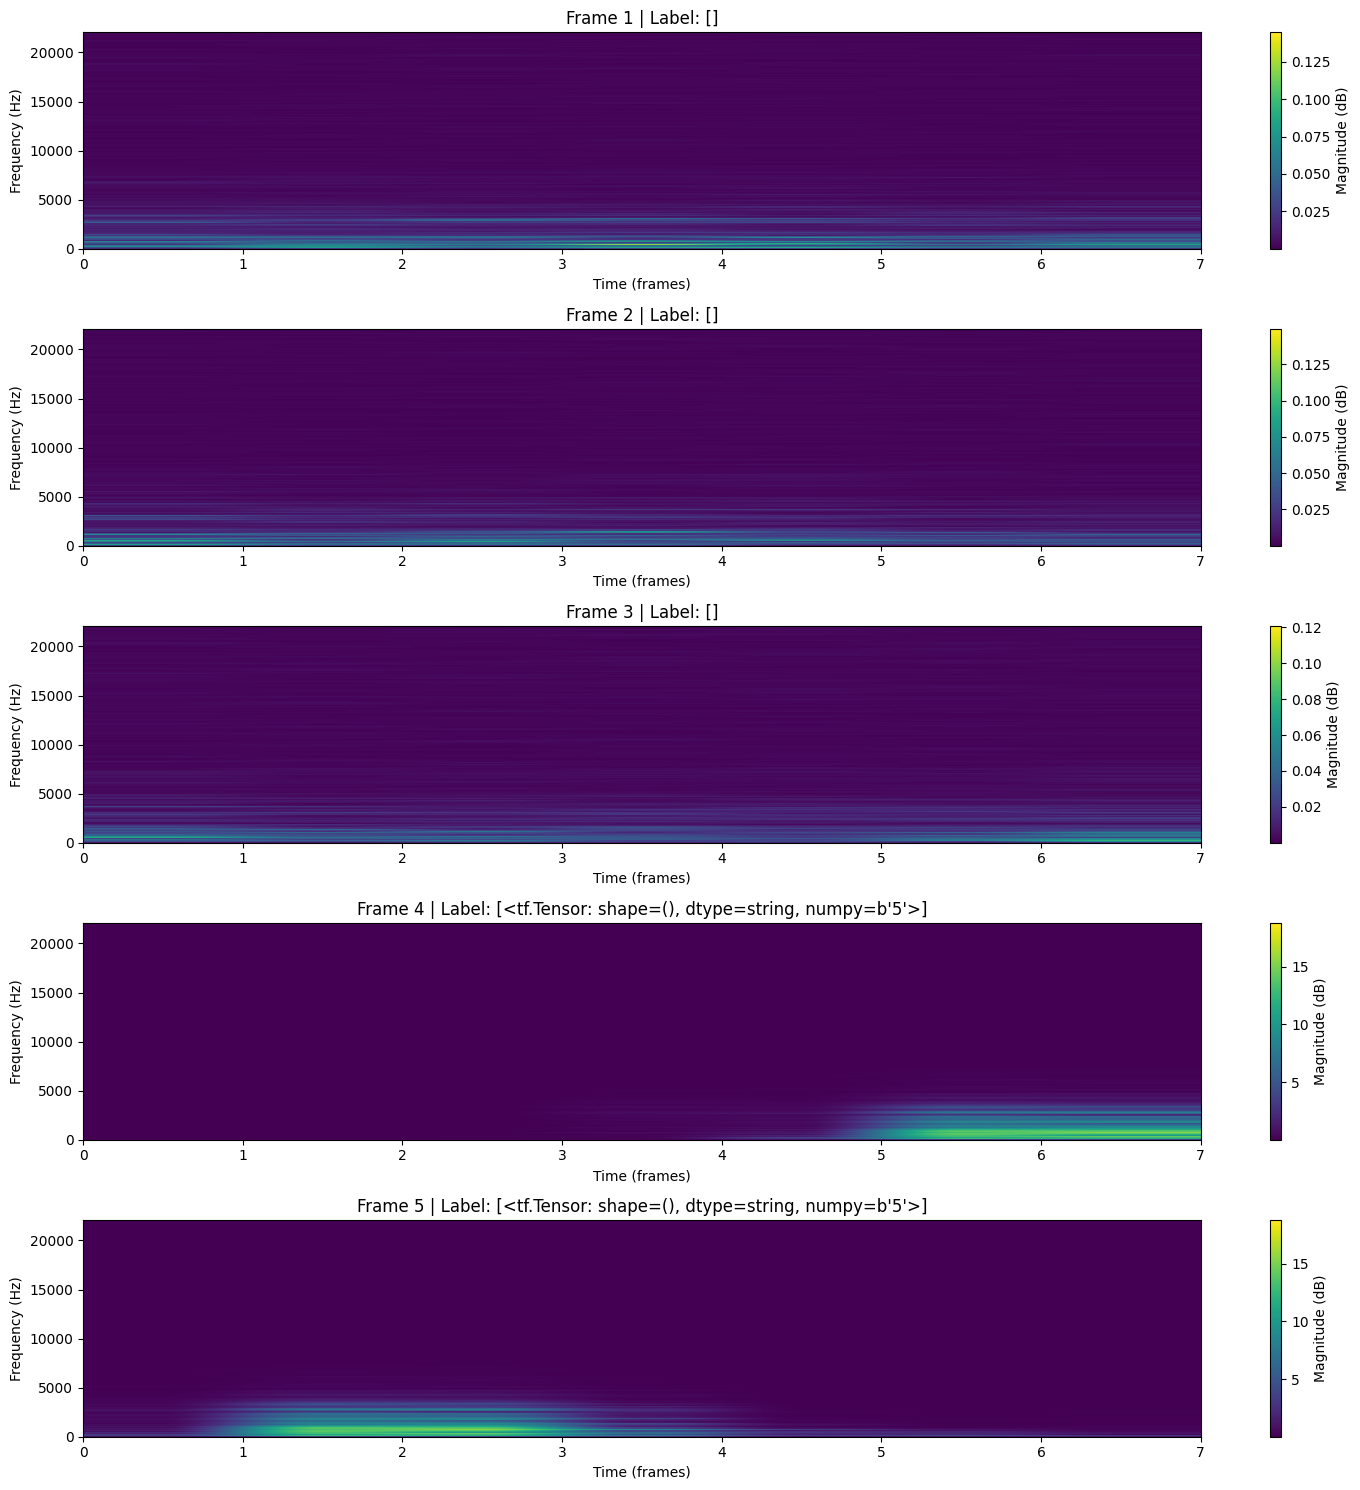

In [ ]:
def plot_spectrogram_sequence(sequence, sample_rate=44100, frame_length=4410, frame_step=2204, label=None):
    sequence_length = sequence.shape[0]
    
    plt.figure(figsize=(15, 3 * sequence_length))  # Adjust figure size based on sequence length

    for i, frame in enumerate(sequence):
        # Compute STFT (Short-Time Fourier Transform)
        stft = tf.signal.stft(
            frame,
            frame_length=frame_length // 4,
            frame_step=frame_step // 4,
            fft_length=frame_length // 2,
        )
        
        # Compute magnitude spectrogram
        spectrogram = tf.abs(stft)
        spectrogram = tf.transpose(spectrogram)  # Transpose for better visualization

        # Plot the spectrogram
        plt.subplot(sequence_length, 1, i + 1)
        plt.imshow(
            10 * tf.math.log1p(spectrogram).numpy(),  # Log-scaled spectrogram
            aspect='auto',
            origin='lower',
            extent=[0, spectrogram.shape[1], 0, sample_rate / 2]
        )
        plt.colorbar(label="Magnitude (dB)")
        title = f"Frame {i + 1}"
        if label is not None:
            title += f" | Label: {label[i]}"
        plt.title(title)
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (frames)")

    plt.tight_layout()
    plt.show()

# ds = flattened_ds.shuffle(10000)
for sequence, label_sequence in flattened_ds.take(1):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])



# Spectrogram Generation

In [318]:
def waveform_to_spectrogram(waveform, label, frame_length=1024, frame_step=256):
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)  # Convert complex values to magnitude
    return spectrogram, label